In [1]:
import os

DATA_DIR = 'C:/Users/dorok/Downloads/Microsoft COCO.v2-raw.tensorflow (1)'
print(os.listdir(DATA_DIR))

['README.dataset.txt', 'README.roboflow.txt', 'train', 'valid']


In [2]:
print(len(os.listdir(DATA_DIR)))

4


In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [4]:
image_size = 40
img_size = [40  ,40]
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [5]:
import pandas as pd

df = pd.read_csv(DATA_DIR+'/train/_annotations.csv')



In [6]:
print(df['class'][0])
listOfPhrases = []
string = ''
prev = str(df['filename'][0])
for i in range(len(df['class'])):
    
    if str(df['filename'][i]) != prev:
        listOfPhrases.append(string)
        string = ''
    string += df['class'][i] + ' '
    prev = str(df['filename'][i])
print(listOfPhrases[0])
    
listOfPhrases.pop(0)
listOfPhrases[114715]
        

sports ball
sports ball person tennis racket person 


'cow cow '

In [7]:
EncodedPhrases = []
import torch
for i in range(len(listOfPhrases)):
    # here are all the unique characters that occur in this text
    chars = sorted(list(set(listOfPhrases[i])))
    vocab_size = len(chars)
    # create a mapping from characters to integers
    stoi = { ch:i for i,ch in enumerate(chars) }
    itos = { i:ch for i,ch in enumerate(chars) }
    encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
    decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

    # Train and test splits
    data = torch.tensor(encode(listOfPhrases[i]), dtype=torch.long)
    #print(len(data))
    EncodedPhrases.append(data)


In [8]:
import gensim
from gensim.models import Word2Vec, KeyedVectors
from torch import nn
import numpy as np

discr_embed = []
embeds = nn.Embedding(len(EncodedPhrases),256)  # 2 words in vocab, 5 dimensional embeddings
ListOfEmbeddings = []
print(len(EncodedPhrases[0]))
for i in range(len(EncodedPhrases)):
    lookup_tensor = torch.tensor(EncodedPhrases[i], dtype=torch.long)
    embed = embeds(lookup_tensor)
    mu, sigma = 0, 0.1 # mean and standard deviation
    s = np.random.normal(mu, sigma, 100)
    embed = sum(embed)
    discr_embed.append(embed)
    embed = embed.detach().numpy()
    embed = np.concatenate((s,embed))
    embed = torch.tensor(embed, dtype=torch.long)
    ListOfEmbeddings.append(embed)
        


21


C:\Users\dorok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


In [10]:

prev = str(df['filename'][i])
counter = 0
for i in range(len(df['filename'])):
    if prev != str(df['filename'][i]):
        os.rename(DATA_DIR+'/train/'+str(df['filename'][i]),DATA_DIR+'/train/'+str(counter)+'.jpg')
        counter += 1
        prev = str(df['filename'][i])

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'C:/Users/dorok/Downloads/Microsoft COCO.v2-raw.tensorflow (1)/train/000000307148_jpg.rf.21738da4b17189cef0156a0c645f2f1a.jpg' -> 'C:/Users/dorok/Downloads/Microsoft COCO.v2-raw.tensorflow (1)/train/0.jpg'

In [9]:
from torchvision import transforms, datasets
from PIL import Image
convert_tensor = transforms.ToTensor()
resize = transforms.Resize(image_size)
listOfTensors = []
for i in range(0,115404):
    img = Image.open(DATA_DIR+'/train/'+str(i)+'.jpg')
    img = img.resize((40,40))
    temp = resize(img)
    temp = convert_tensor(temp)
    listOfTensors.append(temp)



In [10]:

RealImages = []
for i in range(len(listOfTensors)):
    Real_inp = np.concatenate((discr_embed[i].detach().numpy(),listOfTensors[i].detach().numpy().reshape(4800)))
    #Real_inp.reshape(3,64,256)
    RealImages.append(torch.tensor(Real_inp))

In [11]:
WrongImages = []
Real_inp = np.concatenate((discr_embed[len(listOfTensors)-1].detach().numpy(),listOfTensors[0].detach().numpy().reshape(4800)))

WrongImages.append(torch.tensor(Real_inp))
for i in range(len(listOfTensors)-1):
    Real_inp = np.concatenate((discr_embed[i].detach().numpy(),listOfTensors[i+1].detach().numpy().reshape(4800)))
    #Real_inp.reshape(3,64,256)
    WrongImages.append(torch.tensor(Real_inp))

In [12]:

train_dl = DataLoader(RealImages, batch_size, shuffle=True, num_workers=3, pin_memory=True)
train_dlW = DataLoader(WrongImages, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [13]:
EncodedPhrases = ''
ListOfEmbeddings = ''
RealImages = ''
Real_inp = ''
WrongImages = ''
discr_embed = ''
embed = ''
embeds = ''
listOfPhrases = ''
listOfTensors = ''
lookup_tensor = ''

In [14]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [16]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [20]:
show_batch(train_dl)

KeyboardInterrupt: 

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()
device

device(type='cpu')

In [32]:
for i in train_dl:
    print(i)
    break

tensor([[-2.3739e+00,  4.1680e+00, -9.8556e+00,  ...,  4.3137e-01,
          4.7843e-01,  5.0588e-01],
        [ 1.0542e+01,  2.3513e+01, -3.3334e+01,  ...,  3.4510e-01,
          3.5294e-01,  3.6863e-01],
        [-2.3865e+01,  3.2169e+01, -5.3627e+01,  ...,  1.9608e-02,
          1.9608e-02,  1.5686e-02],
        ...,
        [ 9.3197e-02,  2.6628e+00, -5.9731e+00,  ...,  2.8627e-01,
          3.0588e-01,  2.7059e-01],
        [-1.4518e-01,  4.8993e+00, -5.5483e+00,  ...,  3.1373e-01,
          1.6078e-01,  1.8039e-01],
        [ 1.3374e+01,  2.6962e+01, -5.0323e+01,  ...,  5.6471e-01,
          5.5294e-01,  5.6078e-01]])


In [71]:
import torch.nn as nn
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(632, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [72]:
discriminator = to_device(discriminator, device)
latent_size = 356

In [73]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [74]:
xb = []
for i in range(batch_size-1):
    #temp = torch.unsqueeze(ListOfEmbeddings[i],0)
    tmp = ListOfEmbeddings[i]
    tmp = tmp.type(torch.FloatTensor)
    xb.append(tmp)
    #print(len(ListOfEmbeddings[i]))

xb = torch.cat(xb)
xb = xb.reshape(128,356,1,1)
print(xb.shape)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

IndexError: string index out of range

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images,wrong_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator + description
    #discr_embed
    real_images = real_images.resize(128,632,4,1)
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    wrong_preds = discriminator(wrong_images)
    wrong_targets = torch.ones(wrong_images.size(0), 1, device=device)
    wrong_loss = F.binary_cross_entropy(wrong_preds, wrong_targets)
    wrong_score = torch.mean(wrong_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss + wrong_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score,wrong_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    #use created fake images here
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [75]:
from torchvision.utils import save_image
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [76]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [77]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    wrong_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, wrong_images in (zip(train_dl,train_dlW)):
            # Train discriminator
            loss_d, real_score, fake_score,wrong_score = train_discriminator(real_images,wrong_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        wrong_scores.append(wrong_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score,wrong_scores))
    
        # Save generated images
        #save_samples(epoch+start_idx, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores, wrong_scores

In [78]:
lr = 0.0002
epochs = 25


In [79]:
history = fit(epochs, lr)

In [ ]:
losses_g, losses_d, real_scores, fake_scores,wrong_scores = history
print(losses_d)

Text(0.5, 1.0, 'Losses')

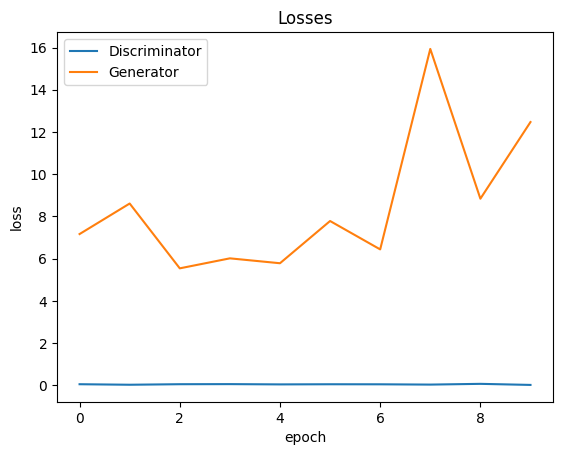

In [ ]:
losses_g, losses_d, real_scores, fake_scores,wrong_scores = history
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')
from IPython.display import Image
Image('./generated/generated-images-0001.png')
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

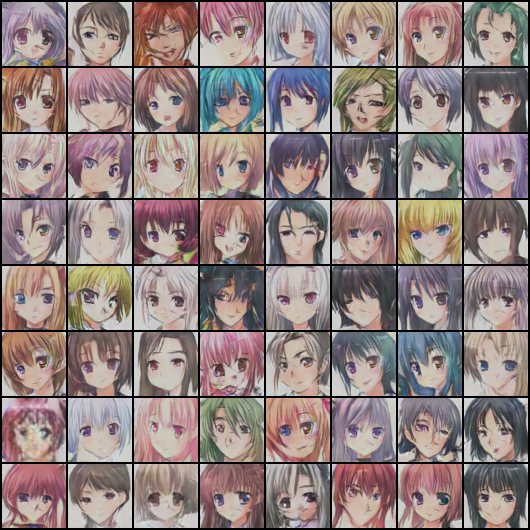

In [ ]:
from IPython.display import Image
Image('./generated/generated-images-0025.png')